# Setup

In [1]:
import sys
import os
import pickle
sys.path.append('..')

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import scripts.cell_extraction_26N 

import importlib
importlib.reload(scripts.cell_extraction_26N)

<module 'scripts.cell_extraction_26N' from '/Users/emiliolr/Desktop/GTC-OTP/notebooks/../scripts/cell_extraction_26N.py'>

# Reading in RAPID array data in depth-space and plotting

In [2]:
data_home = "/Users/emiliolr/Google Drive/My Drive/GTC"
rapid_depth = xr.open_dataset(os.path.join(data_home, 'rapid_26N', 'moc_vertical.nc'))

rapid_depth

<xarray.Dataset>
Dimensions:              (time: 13057, depth: 307)
Coordinates:
  * time                 (time) datetime64[ns] 2004-04-02 ... 2022-02-15
  * depth                (depth) float64 0.0 19.87 39.74 ... 5.976e+03 5.995e+03
Data variables:
    stream_function_mar  (depth, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

In [4]:
# This temp and salinity data may not be useful for calculating potential density since it's
#   aggregated over longitudes...
rapid_temp_sal = xr.open_dataset(os.path.join(data_home, 'rapid_26N', 'ts_gridded.nc'))
rapid_temp_sal

<xarray.Dataset>
Dimensions:          (time: 13057, depth: 242)
Coordinates:
  * time             (time) datetime64[ns] 2004-04-02 ... 2022-02-15
Dimensions without coordinates: depth
Data variables: (12/19)
    pressure         (depth) float64 ...
    TG_west          (depth, time) float64 ...
    SG_west          (depth, time) float64 ...
    TG_wb3           (depth, time) float64 ...
    SG_wb3           (depth, time) float64 ...
    TG_east          (depth, time) float64 ...
    ...               ...
    TG_east_flag     (depth, time) float64 ...
    SG_east_flag     (depth, time) float64 ...
    TG_marwest_flag  (depth, time) float64 ...
    SG_marwest_flag  (depth, time) float64 ...
    TG_mareast_flag  (depth, time) float64 ...
    SG_mareast_flag  (depth, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

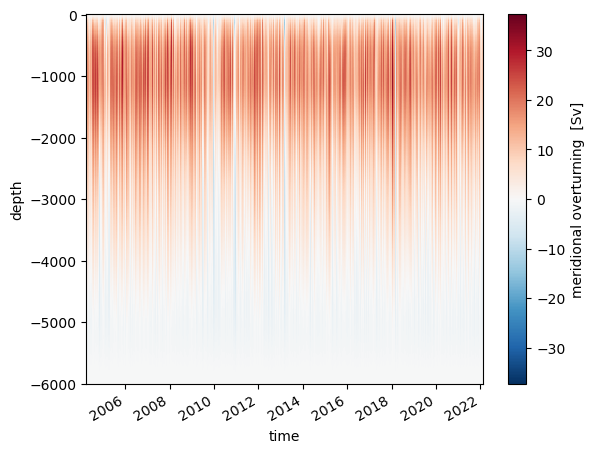

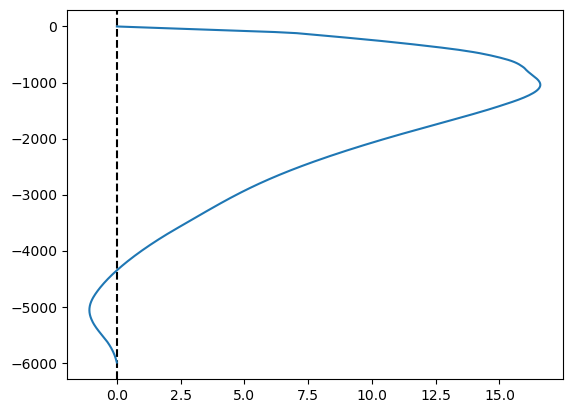

In [5]:
# Pretty sure this is integrating from sea surface down to different depths rather than bottom up...
rapid_flipped = rapid_depth.stream_function_mar.assign_coords({'depth' : -1 * rapid_depth.depth})

rapid_flipped.plot()
plt.show()

plt.axvline(0, color = 'black', linestyle = '--')
plt.plot(rapid_flipped.mean('time'), rapid_flipped.depth)
plt.show()

# Extracting the two cells and the switch point for a 5-month sliding window

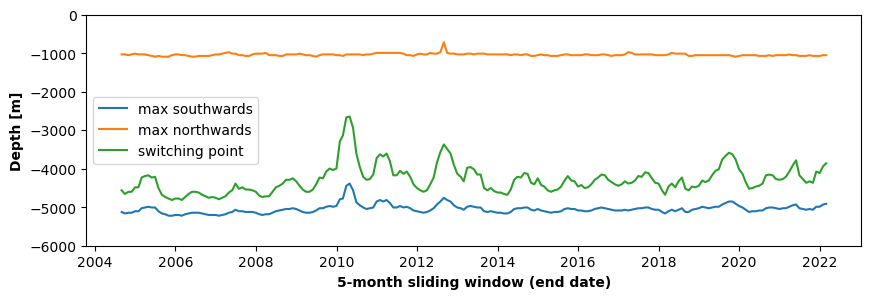

In [6]:
# Calculating the lower/upper cell depths and switch points
min_depths, max_depths, zero_depths, new_time = scripts.cell_extraction_26N.sliding_window_min_max_mix(rapid_flipped)

# Plot these over time--not quite sure how to interpret time dimension because of windows...
plt.figure(figsize = (10, 3))

plt.plot(new_time, min_depths, label = 'max southwards')
plt.plot(new_time, max_depths, label = 'max northwards')
plt.plot(new_time, zero_depths, label = 'switching point')

plt.ylim(-6000, 0)

plt.ylabel('Depth [m]', weight = 'bold')
plt.xlabel('5-month sliding window (end date)', weight = 'bold')

plt.legend();

# Taking a look at the two cells and switch point in ECCO density-space

In [7]:
# Grabbing the time values for ECCO data
time = xr.open_dataset(os.path.join(data_home, 'ecco_data_minimal', '26N.nc')).time.values

In [8]:
# Grabbing density mappings
with open(os.path.join(data_home, 'ecco_data_minimal', '26N_original_density_range.pickle'), 'rb') as f:
    density_range = pickle.load(f)

In [9]:
# Loading density-space ECCO data
ecco_streamfunction_density_fp = os.path.join(data_home, 'ecco_data_minimal', '26N_streamfunction_density.pickle')

with open(ecco_streamfunction_density_fp, 'rb') as f:
    ecco_streamfunction_density = pickle.load(f)

# Put into an xarray dataset for convenience
ecco_strf = xr.Dataset(data_vars = {'streamfunction' : (['density_layer', 'time'], ecco_streamfunction_density)}, 
                     coords = {'time' : time, 'density_layer' : density_range})

ecco_strf

<xarray.Dataset>
Dimensions:         (density_layer: 100, time: 312)
Coordinates:
  * time            (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T...
  * density_layer   (density_layer) float64 27.82 27.92 28.02 ... 37.63 37.73
Data variables:
    streamfunction  (density_layer, time) float64 6.305 7.511 ... -0.0 -0.0

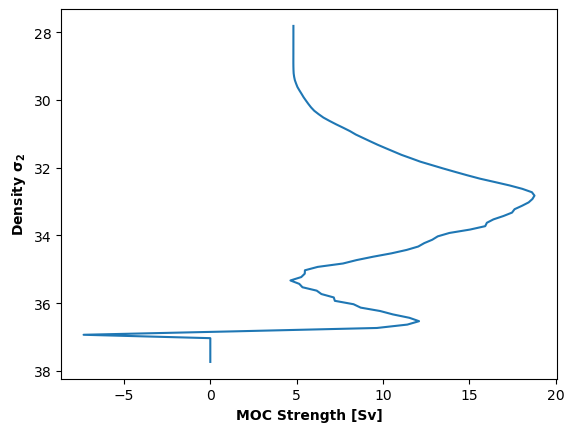

In [10]:
# Plotting streamfunction mean against density layer
plt.plot(ecco_strf.streamfunction.mean('time'), ecco_strf.density_layer)
plt.gca().invert_yaxis()

# plt.ylim(37, 35)

plt.xlabel('MOC Strength [Sv]', weight = 'bold')
plt.ylabel('Density $\\mathbf{\\sigma_2}$', weight = 'bold');

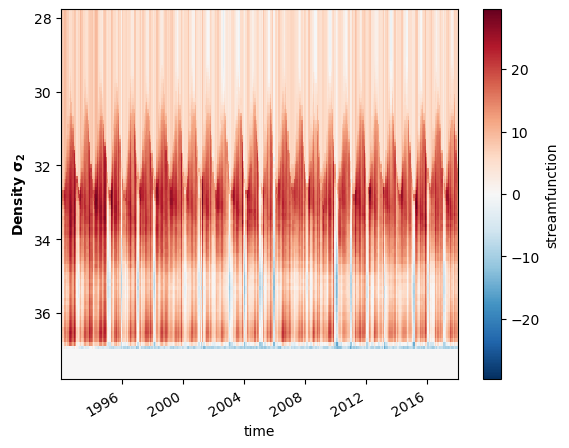

In [11]:
# Plotting streamfunction for density layer vs. time
ecco_strf.streamfunction.plot()
plt.gca().invert_yaxis()

plt.ylabel('Density $\\mathbf{\\sigma_2}$', weight = 'bold');

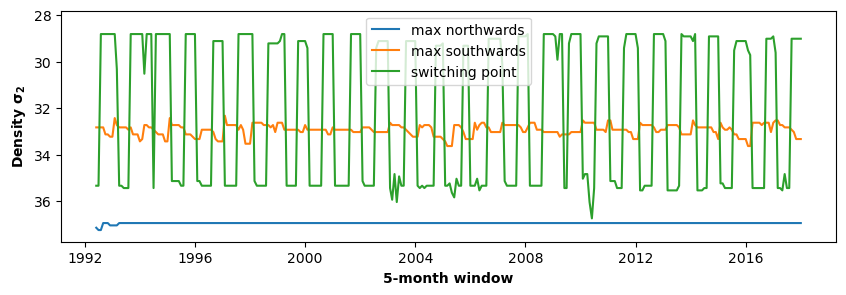

In [12]:
min_depths, max_depths, zero_depths, new_time = scripts.cell_extraction_26N.sliding_window_min_max_mix(ecco_strf.streamfunction, 
                                                                                                       depth_coord_name = 'density_layer', 
                                                                                                       remove_above_depth = None,
                                                                                                       ignore_first_last = 10)

plt.figure(figsize = (10, 3))

plt.plot(new_time, min_depths, label = 'max northwards')
plt.plot(new_time, max_depths, label = 'max southwards')
plt.plot(new_time, zero_depths, label = 'switching point')

plt.ylim(density_range.min(), density_range.max())
plt.gca().invert_yaxis()

plt.ylabel('Density $\\mathbf{\\sigma_2}$', weight = 'bold')
plt.xlabel('5-month window', weight = 'bold')

plt.legend();

# Fiddling with ECCO depth-space streamfunction

In [14]:
ecco_streamfunction_depth_fp = os.path.join(data_home, 'ecco_data_minimal', '26N_streamfunction_depth.pickle')

with open(ecco_streamfunction_depth_fp, 'rb') as f:
    ecco_streamfunction_depth = pickle.load(f)

ecco_strf_depth = xr.Dataset(data_vars = {'streamfunction' : (['depth_layer', 'time'], ecco_streamfunction_depth)}, 
                     coords = {'time' : time, 'depth_layer' : np.arange(len(ecco_streamfunction_depth))})

ecco_strf_depth

<xarray.Dataset>
Dimensions:         (depth_layer: 50, time: 312)
Coordinates:
  * time            (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T...
  * depth_layer     (depth_layer) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
Data variables:
    streamfunction  (depth_layer, time) float64 -0.0 -0.0 -0.0 ... 6.263 5.194

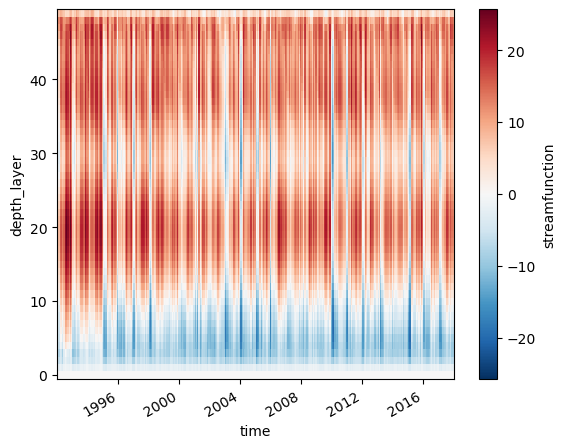

In [15]:
ecco_strf_depth.streamfunction.plot();

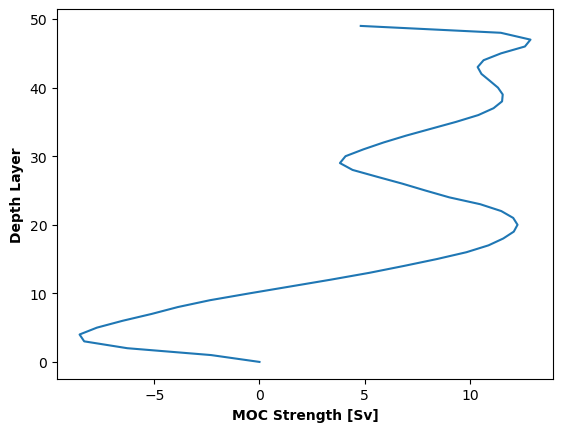

In [16]:
plt.plot(ecco_strf_depth.streamfunction.mean('time'), ecco_strf_depth.depth_layer)

plt.xlabel('MOC Strength [Sv]', weight = 'bold')
plt.ylabel('Depth Layer', weight = 'bold');

In [17]:
bolus_26 = xr.open_dataset(os.path.join(data_home, '[OLD] streamfunctions_ecco', '26.5N', 'PSI_bolus26.5N.nc'))
residual_26 = xr.open_dataset(os.path.join(data_home, '[OLD] streamfunctions_ecco', '26.5N', 'PSI_residual26.5N.nc'))
ecco_strf_tot26 = bolus_26 + residual_26

ecco_strf_tot26

<xarray.Dataset>
Dimensions:  (k: 50, lat: 1, time: 312)
Coordinates:
    Z        (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * lat      (lat) float64 26.5
  * time     (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    trsp_z   (time, k, lat) float64 5.326 0.2809 -0.4275 ... 0.3389 -0.0595
    psi_moc  (time, k, lat) float64 2.062 7.388 7.669 ... -1.015 -0.2794 0.0595
    moc      (time, lat) float64 20.7 22.39 24.98 23.75 ... 20.45 21.91 23.02

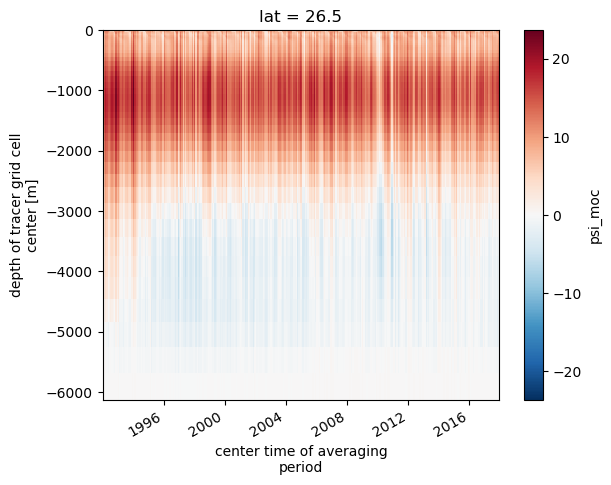

In [18]:
ecco_strf_tot26.psi_moc.plot(x = 'time', y = 'Z');

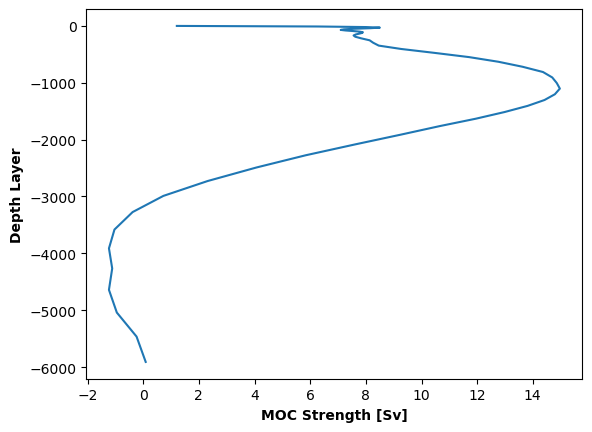

In [19]:
plt.plot(ecco_strf_tot26.psi_moc.mean('time'), ecco_strf_tot26.Z)

plt.xlabel('MOC Strength [Sv]', weight = 'bold')
plt.ylabel('Depth Layer', weight = 'bold');

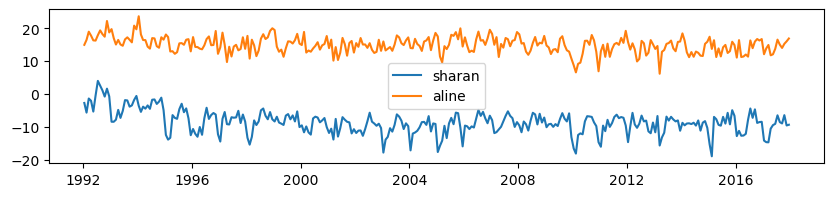

In [20]:
moc_depth_fp = os.path.join(data_home, 'ecco_data_minimal', '26N_moc_depth.pickle')

with open(moc_depth_fp, 'rb') as f:
    sharan_moc = pickle.load(f)

depth_to_use = np.argmax(ecco_strf_tot26.psi_moc.mean('time').squeeze().values)
aline_moc = ecco_strf_tot26.psi_moc.squeeze().values[ : , depth_to_use]

plt.figure(figsize = (10, 2))

plt.plot(ecco_strf_tot26.time, sharan_moc[0, 1, : ], label = 'sharan')
plt.plot(ecco_strf_tot26.time, aline_moc, label = 'aline')

plt.legend();

# Checking out MOC outputs for Sharan's implementation (depth- and density-space)

In [39]:
ecco_moc_60s_fp = os.path.join(data_home, 'ecco_data_minimal', '60s_moc_density.pickle')

with open(ecco_moc_60s_fp, 'rb') as f:
    ecco_moc_60s = pickle.load(f)
    
ecco_moc_60s = ecco_moc_60s
ecco_moc_60s.shape

(3, 3, 312)

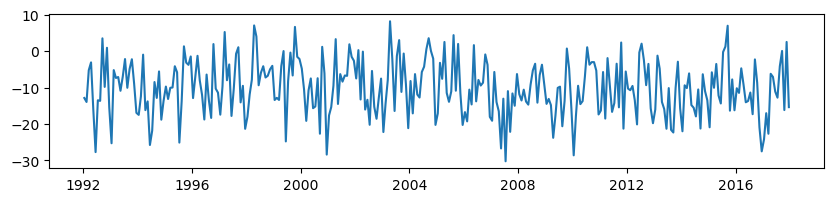

In [40]:
plt.figure(figsize = (10, 2))

plt.plot(time, ecco_moc_60s[1, 1, : ])